In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
# Create an array of 1000 evenly spaced points between 0 and 2π
x = np.linspace(0, 2*np.pi, 100)

# Define three different phases (0, 2π/3, 4π/3)
phases = np.array([0, 2*np.pi/3, 4*np.pi/3])

# Initialize array to store cosine values for each phase
cos_values = np.zeros((len(x), 51))

# Generate 17 samples for each phase (17 * 3 = 51 total samples)
for i, phase in enumerate(phases):
    start_idx = i * 17
    end_idx = start_idx + 17
    cos_values[:, start_idx:end_idx] = np.cos(x[:, np.newaxis] - phase)

cos_values.shape


(100, 51)

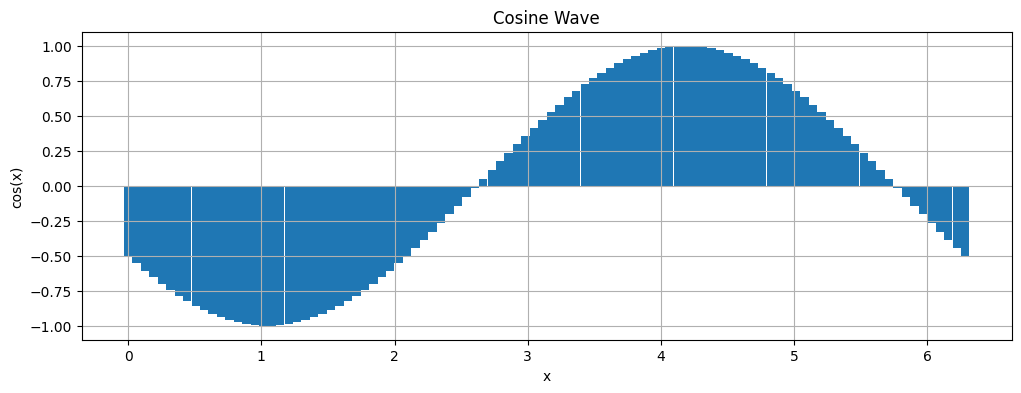

In [3]:
# Plot the cosine wave to visualize the result
plt.figure(figsize=(12, 4))
plt.bar(x, cos_values[:,50], width=(2*np.pi/100))
plt.title('Cosine Wave')
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.grid(True)
plt.show()

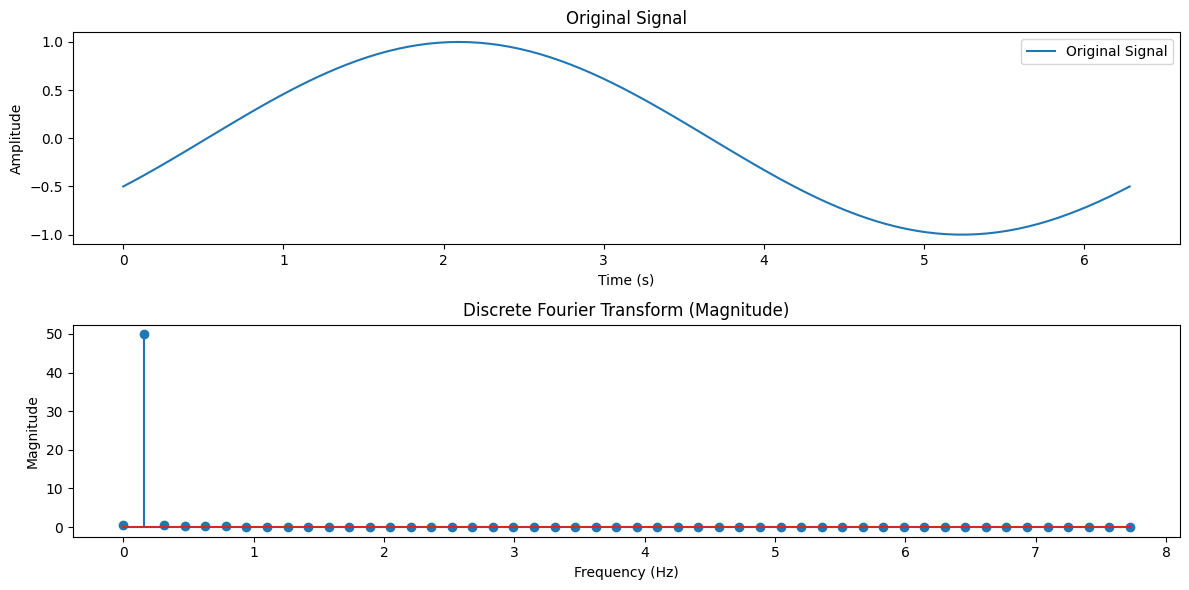

In [4]:
# Compute the DFT
dft = np.fft.fft(cos_values[:,20])  # DFT of the signal
frequencies = np.fft.fftfreq(len(cos_values[:,20]), d=x[1] - x[0])  # Frequency bins
# Magnitude of the DFT
magnitude = np.abs(dft)
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, cos_values[:,20], label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:len(cos_values[:,20])//2], magnitude[:len(cos_values[:,20])//2])
plt.title("Discrete Fourier Transform (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()


In [5]:
# Normalize to get a probability distribution
probabilities = magnitude / np.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -np.sum(probabilities * np.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 1.1849313034491824


In [6]:
# Create random permutation of rows
np.random.seed(42)  # For reproducibility
dataset = np.zeros_like(cos_values)
perm_indices = np.random.permutation(cos_values.shape[0])

# Apply permutation to create new dataset
for i in range(cos_values.shape[0]):
    dataset[i,:] = cos_values[perm_indices[i],:]

print(dataset.shape)


(100, 51)


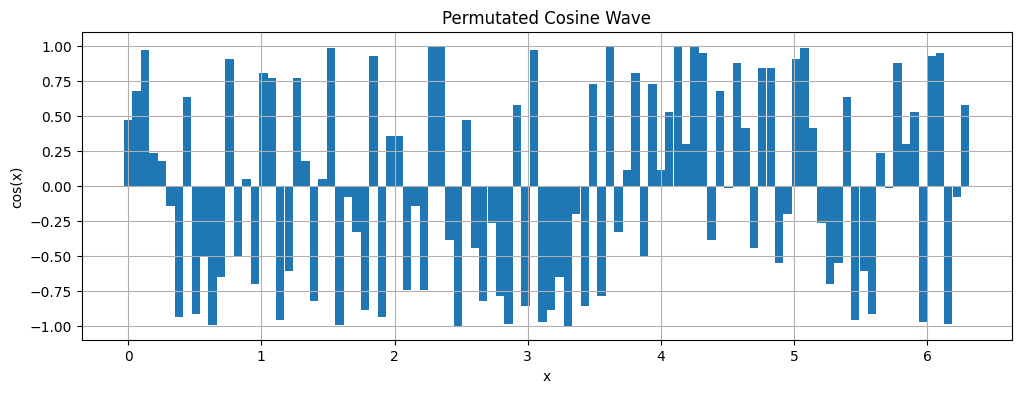

In [7]:
# Plot the cosine wave to visualize the result
plt.figure(figsize=(12, 4))
plt.bar(x, dataset[:,34], width=(2*np.pi/100))
plt.title('Permutated Cosine Wave')
plt.xlabel('x')
plt.ylabel('cos(x)')
plt.grid(True)
plt.show()

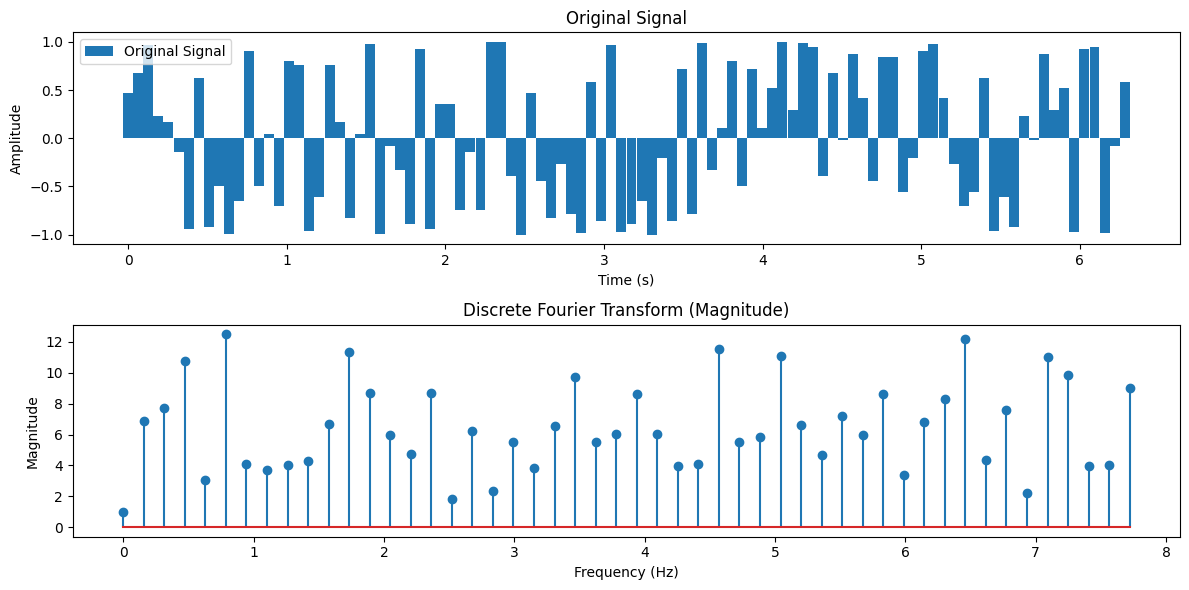

In [8]:
# Compute the DFT
dft = np.fft.fft(dataset[:,0])  # DFT of the signal
frequencies = np.fft.fftfreq(len(dataset[:,0]), d=x[1] - x[0])  # Frequency bins
# Magnitude of the DFT
magnitude = np.abs(dft)
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.bar(x, dataset[:,34], width=(2*np.pi/100),label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:len(dataset[:,0])//2], magnitude[:len(dataset[:,0])//2])
plt.title("Discrete Fourier Transform (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

In [9]:
# Normalize to get a probability distribution
probabilities = magnitude / np.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -np.sum(probabilities * np.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 4.509609105901869


In [10]:
# Dataset
dataset_torch = torch.tensor(dataset, dtype=torch.float32)  # Convert numpy array to PyTorch tensor

In [11]:
dataset_torch.shape

torch.Size([100, 51])

In [12]:
# Compute the DFT
dft = torch.fft.fft(dataset_torch[:,0])  # Forward Fourier Transform
frequencies = torch.fft.fftfreq(100, d=(x[1] - x[0]).item())  # Frequency bins

# Magnitude of the DFT
magnitude = torch.abs(dft)

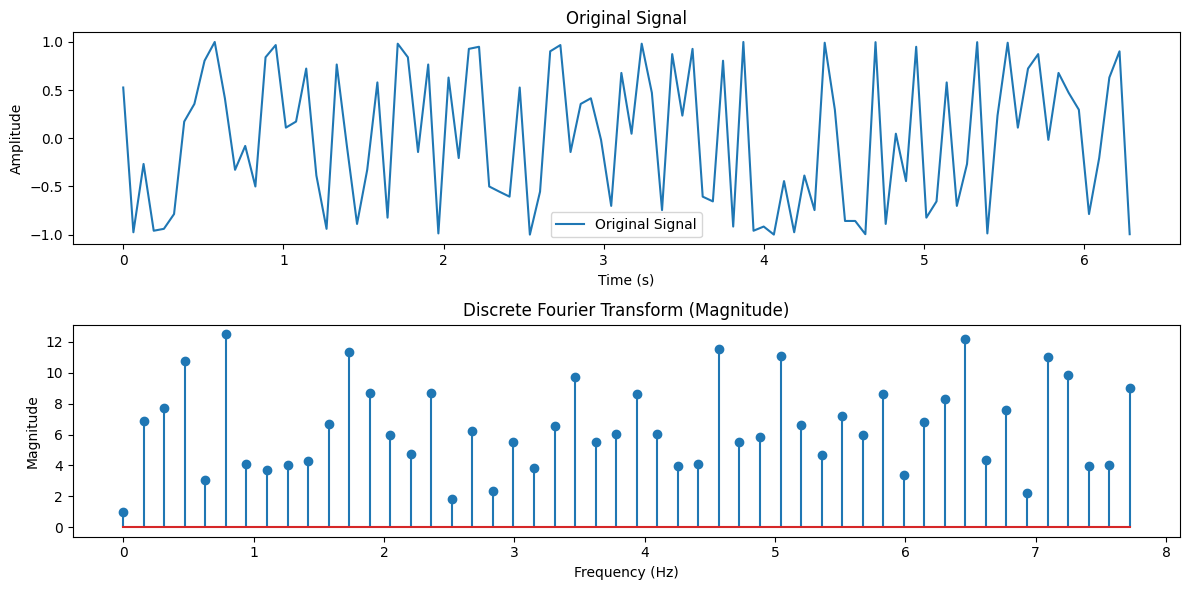

In [13]:
# Plot the original signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(x, dataset_torch[:,0].numpy(), label="Original Signal")
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Plot the magnitude of the DFT
plt.subplot(2, 1, 2)
plt.stem(frequencies[:100//2].numpy(), magnitude[:100//2].numpy())
plt.title("Discrete Fourier Transform (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

In [14]:
# Normalize to get a probability distribution
probabilities = magnitude / torch.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -torch.sum(probabilities * torch.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 4.509608745574951


In [75]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 20), 
            nn.ReLU(),
            nn.Linear(20, 10), 
            nn.ReLU(),
            nn.Linear(10, 1),
        )

        self.decoder = nn.Sequential(
            nn.Linear(1, 10),    
            nn.ReLU(),
            nn.Linear(10, 20),  
            nn.ReLU(),
            nn.Linear(20, input_dim)
            # nn.Sigmoid()         
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed

In [81]:
# Sort the dataset according to latent pseudotime 
def reorder_by_pseudotime(dataset, latent_values):
    order = torch.argsort(latent_values.squeeze())  
    return dataset[order]

# Compute the DFT and entropy
def compute_entropy(dft):
    magnitude = torch.abs(dft)
    probabilities = magnitude / torch.sum(magnitude)
    
    # Avoid log(0) by adding eps
    eps = 1e-12
    entropy = -torch.sum(probabilities * torch.log(probabilities + eps))
    return entropy

In [82]:
dataset_torch.shape

torch.Size([100, 51])

In [85]:
autoencoder = Autoencoder(input_dim=dataset_torch.shape[1])
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 1000
ent = []
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    latent_values, reconstructed = autoencoder(dataset_torch)
    # Reorder the dataset based on latent time
    reordered_dataset = reorder_by_pseudotime(reconstructed, latent_values)
    # Compute the DFT 
    entropy = 0
    for i in range(reordered_dataset.size(1)):
        dft = torch.fft.fft(reordered_dataset[:,i])
        # Compute entropy 
        entropy =+ compute_entropy(dft)
    # Reconstruction loss (mean squared error)
    reconstruction_loss = nn.MSELoss()(reconstructed, dataset_torch)
    ent.append(entropy.item())
    # Total loss: reconstruction loss + entropy minimization
    total_loss = reconstruction_loss + entropy
    # total_loss = entropy
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {total_loss.item():.4f}")


Epoch [0/1000], Loss: 1.3591
Epoch [100/1000], Loss: 0.5023
Epoch [200/1000], Loss: 0.5014
Epoch [300/1000], Loss: 0.5012
Epoch [400/1000], Loss: 0.5008
Epoch [500/1000], Loss: 0.5010
Epoch [600/1000], Loss: 0.5007
Epoch [700/1000], Loss: 0.5005
Epoch [800/1000], Loss: 0.5005
Epoch [900/1000], Loss: 0.5008


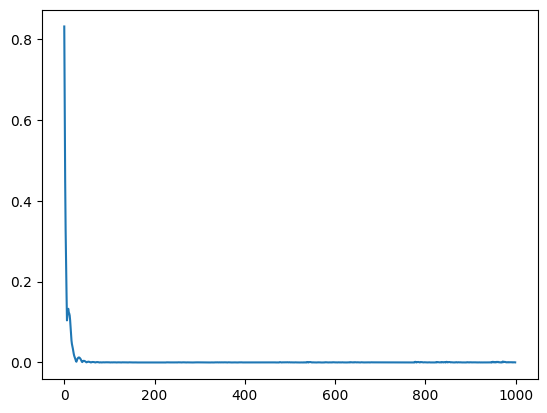

In [86]:
plt.plot(ent)

In [48]:
dft = torch.fft.rfft(reordered_dataset)

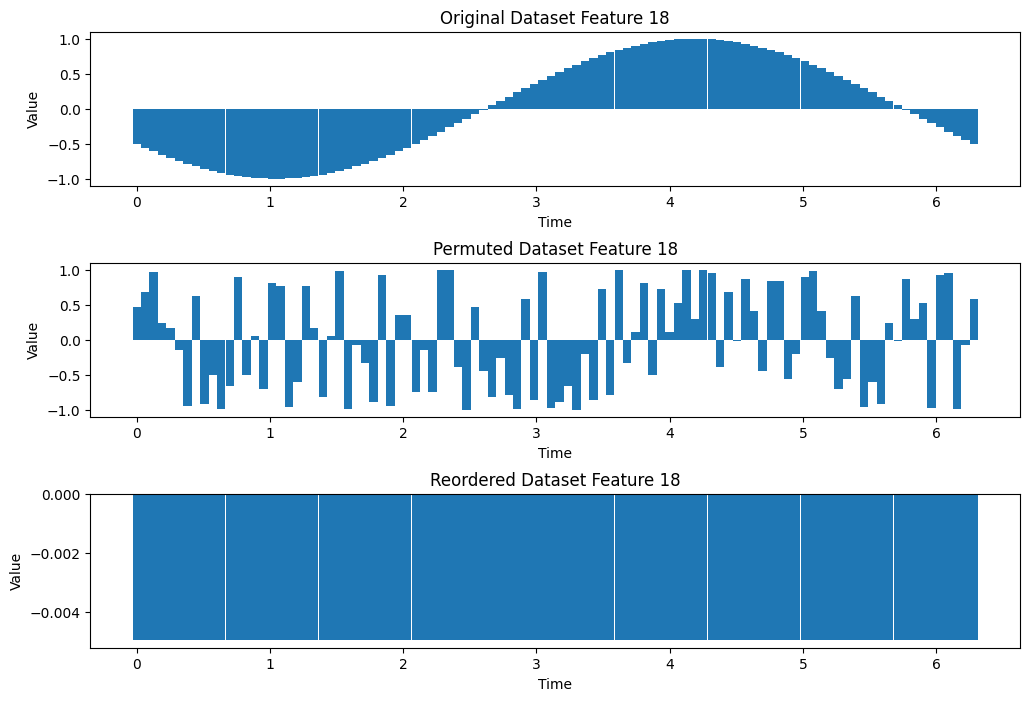

In [74]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.bar(x, cos_values[:,34], width=(2*np.pi/100))
plt.title("Original Dataset Feature 18")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(3, 1, 2)
plt.bar(x, dataset[:,34], width=(2*np.pi/100))
plt.title("Permuted Dataset Feature 18")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(3, 1, 3)
reordered_dataset_np = reordered_dataset.detach().numpy()
plt.bar(x, reordered_dataset_np[:,34], width=(2*np.pi/100))
plt.title("Reordered Dataset Feature 18")
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing between subplots
plt.show()

In [60]:
dft = np.fft.fft(reordered_dataset_np[:,34])  # DFT of the signal
frequencies = np.fft.fftfreq(len(reordered_dataset_np[:,34]), d=x[1] - x[0])  # Frequency bins
# Magnitude of the DFT
magnitude = np.abs(dft)

# Normalize to get a probability distribution
probabilities = magnitude / np.sum(magnitude)

# Avoid log(0) by adding a small constant (numerical stability)
eps = 1e-12
entropy = -np.sum(probabilities * np.log(probabilities + eps))

print(f"Entropy of the DFT: {entropy.item()}")

Entropy of the DFT: 0.09769057482481003


In [74]:
probabilities.shape

(100,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


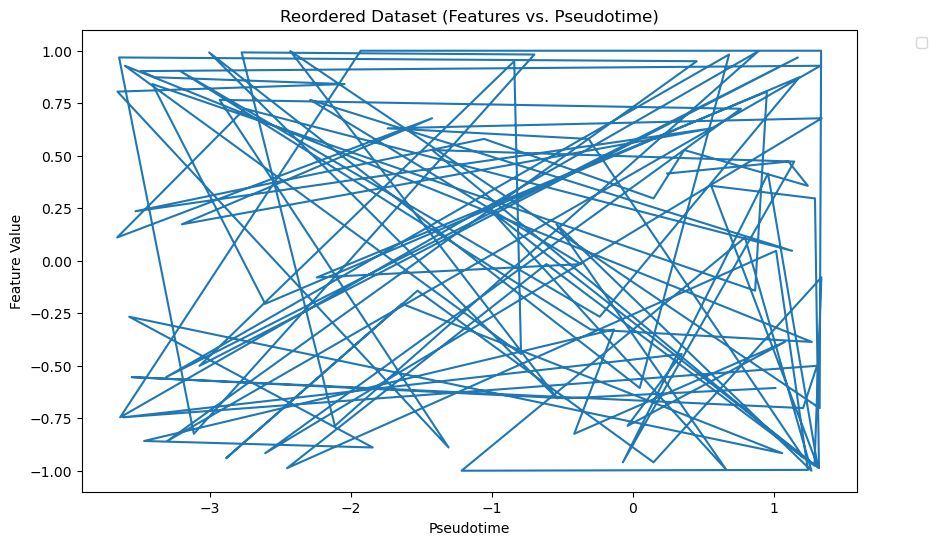

In [207]:
# Assuming `reordered_dataset` is your dataset reordered based on pseudotime
# If the original dataset has shape (100, 51), you can plot each feature over pseudotime

reordered_dataset = reordered_dataset.detach().numpy()  # Convert to numpy array for visualization

# Plot the features of the reordered dataset over pseudotime
plt.figure(figsize=(10, 6))
# for i in range(reordered_dataset.shape[1]):  # Loop over each feature
plt.plot(latent_values, reordered_dataset[:, 0])
plt.xlabel("Pseudotime")
plt.ylabel("Feature Value")
plt.title("Reordered Dataset (Features vs. Pseudotime)")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()
